In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
# standard libraries and classes
import os
import sys
import time
import string
import logging
import cProfile
import pstats
import pprint
import collections

from os import walk
from io import StringIO

# third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns


# frequently used classes

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, roc_auc_score
from IPython.core.debugger import Tracer
from IPython.display import display, Image
from functools import wraps
from datetime import datetime as dt
from pandas import DataFrame
from xgboost.sklearn import XGBClassifier
from scipy.stats import randint, uniform
from six.moves import cPickle as pickle
#from __future__ import print_function


# custom imports and settings

import helper_functions as hf
%reload_ext autoreload
%autoreload 2
%reload_ext version_information
%matplotlib inline
version_list = %version_information numpy, scipy, matplotlib, pandas, scikit-learn, xgboost, tensorflow
version_list_html= hf.dict_to_html(version_list.__dict__['packages'])
plt.rcParams['figure.figsize'] = (20,10)

In [4]:
# run_pickle = hf.pickler('runpickles/20170905/run_20170905153659')
# pprint.pprint(run_pickle)
# context = run_pickle['run context']

In [5]:
context = hf.fetch_paths()
pickled = hf.pickler(context['pickle'], context, 'run context')
hf.objects_growth(context['summary'], 'Beginning Heap')
hf.write_dict({'Installed Versions':version_list.__dict__['packages']}, context['summary'], 'Software Versions')
hf.write_dict(context, context['summary'], 'Run time Context')

#profiler = cProfile.Profile()


{'log path': 'logs/20170912/',
 'model path': 'savedmodels/20170912/',
 'modelpickles': 'savedmodels/20170912/pickled_20170912214951',
 'pickle': 'runpickles/20170912/run_20170912214951',
 'plot path': 'plots/20170912/run_214951/',
 'run date': '20170912',
 'run time': '214951',
 'runprofiles path': 'runprofiles/20170912/',
 'stats path': 'stats/20170912/',
 'statsfile': 'stats/20170912/stats_20170912214951',
 'summary': 'runprofiles/20170912/summary_20170912214951.txt'}

In [19]:
load_stats ={}

size = 50
image_size =28
num_labels =  10

data_pickle_path = '../../../tensorflow/tensorflow/examples/udacity/notMNIST.pickle'

with open(data_pickle_path, 'rb') as f:
    data = pickle.load(f)

train_dataset = data['train_dataset']
length = train_dataset.shape[0]
train_dataset = train_dataset.reshape(length, image_size*image_size)

valid_dataset = data['valid_dataset']
length = valid_dataset.shape[0]
valid_dataset = valid_dataset.reshape(length, image_size*image_size)

test_dataset = data['test_dataset']
length = valid_dataset.shape[0]
test_dataset = test_dataset.reshape(length, image_size*image_size)

valid_labels = data['valid_labels']
train_labels = data['train_labels']
test_labels = data['test_labels']

#be nice to your RAM
del data

load_stats.update({'training dataset': train_dataset.shape})
load_stats.update({'training labels': train_labels.shape})
load_stats.update({'validations dataset': valid_dataset.shape})
load_stats.update({'validation labels': valid_labels.shape})
load_stats.update({'test dataset': test_dataset.shape})
load_stats.update({'test labels': test_labels.shape})

############## WRITE TO SUMMARY FILE
hf.write_dict(load_stats, context['summary'],'Dataset Details')

datasets = [train_dataset, valid_dataset, test_dataset]
labels = [train_labels, valid_labels, test_labels]

trial_datasets = [valid_dataset, test_dataset, valid_dataset]
trial_labels = [valid_labels, test_labels, valid_labels]

test_datasets =[]
test_labels =[]

In [20]:
tree_tuner = XGBClassifier(
                        learning_rate = 0.5,
                        n_estimators = 600,
                        max_depth = 2,
                        min_child_weight=1,
                        gamma = 0,
                        subsample = 0.3,
                        colsample_bytree = 0.3,
                        objective= 'multi:softmax',
                        #num_class=10,
                        #n_jobs=-1,
                        #scale_pos_weight=0,
                        seed=27)


Model Report
Accuracy : 0.89400
Optimal Boosters : 63


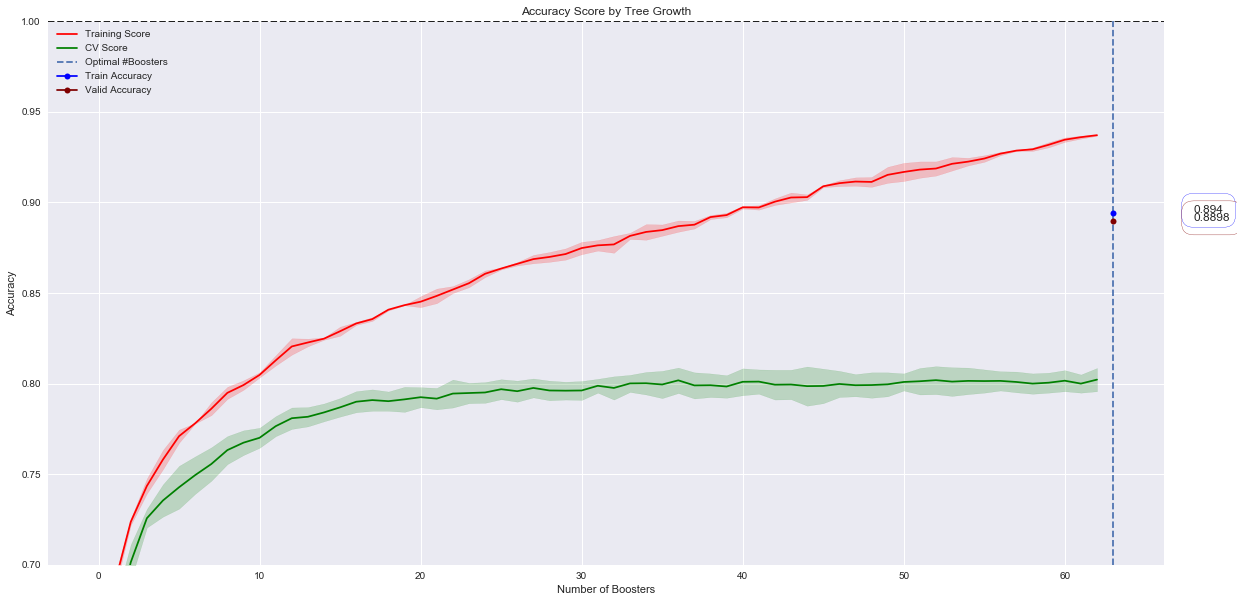

In [24]:
initial_result = hf.modelfit(tree_tuner, trial_datasets, trial_labels, context, 'merror', num_labels = num_labels, cv_folds=2)


In [29]:
#Score on the test dataset
pickled = hf.pickler(context['modelpickles'])
#pprint.pprint(pickled)
xgboosted = pickled['model']
predicted = xgboosted.predict(test_dataset)
pre_accuracy = accuracy_score(test_labels, predicted)
hf.write_dict({' Test Accuracy:': pre_accuracy }, context['summary'],'Accuracy before tuning')
print(pre_accuracy)

0.9564


In [33]:
## TUNER PARAMETERS

# set ranges for parameters to be tuned by GridSearch. Includes upper limit
allowed_ranges = {
    'colsample_bylevel': [0,1],
    'colsample_bytree': [0,1],
    'gamma': [0,1],
    'learning_rate': [0,1],
    #'max_delta_step': 0,
    'max_depth': [1,10],
    'min_child_weight': [1,10],
    #'missing': None,
    #'reg_alpha': [0,100],
    'reg_lambda': [1,10],
    'scale_pos_weight': [1,5],
    'subsample': [0,1]}

# set magnitude of steps to traverse while fine-tuning grid search
steps = {
    'colsample_bylevel': 0.05,
    'colsample_bytree': 0.05,
    'gamma': 0.1,
    'learning_rate': 0.01,
    #'max_delta_step': 0,
    'max_depth': 1,
    'min_child_weight': 1,
    #'missing': None,
    #'reg_alpha': [0,100],
    'reg_lambda': 0.25,
    'scale_pos_weight': 1,
    'subsample': 0.05}

In [ ]:
tuning_rounds =10
tuner_params =[{'max_depth':[3,7], 'min_child_weight':[3,7]},
            {'gamma':[.2,.5,.8]},
            {'subsample':[.3,.7], 'colsample_bytree':[.3,.7]},
            {'reg_lambda':[2,5,8] }]

for i in range(len(tuner_params)):
    final_result = tuner_cv(train_dataset, train_labels, valid_dataset, valid_labels, 
                            tuner_params[i], tuning_rounds, context, cv=5)       

In [ ]:
# Now tune reg_alpha
best_alpha ={}
pickled = hf.pickler(context['pickle'])
parameters = pickled['optimal parameters']
param_test = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05] }

estimator = XGBClassifier(**parameters)

gsearch_alpha = GridSearchCV(estimator = estimator, 
                        param_grid = param_test, 
                        scoring= 'accuracy',
                        n_jobs= -1,
                        cv= 5)
optimal_alpha = gsearch_alpha.fit(train_dataset,train_labels)

#print('Best parameter', optimal_alpha.best_params_, 'CV Accuracy: ', optimal_alpha.best_score_)
# Update the parameters list with best scoring parameter
parameters.update({k: optimal_alpha.best_params_[k] for k in optimal_alpha.best_params_})


# Update the pickle
updated_pickle = hf.pickler(context['pickle'], parameters, 'optimal parameters')

# Write to summary file
best_alpha.update({'Chosen:':str(optimal_alpha.best_params_) + ' CV Score:' + str(optimal_alpha.best_score_)})   
hf.write_dict(best_alpha, context['summary'],'alpha Grid Search Result')

In [ ]:
# Now lower learning rate and find optimal number of boosters
pickled = hf.pickler(context['pickle'])
parameters = pickled['optimal parameters']
parameters.update({'n_estimators': 5000})
parameters.update({'learning_rate': 0.01})

final_tuner = tree_tuner = XGBClassifier(**parameters)

optimal_model = hf.modelfit(final_tuner,train_dataset,train_labels,valid_dataset,valid_labels, 
                            context, 'merror', num_labels =num_labels, cv_folds=5)



In [32]:
def tuner_cv(train_set, train_labels, val_set, val_labels, param_test, tuning_rounds, context, scoring ='accuracy', cv = 3, val_tuned =True):
    pickled = hf.pickler(context['pickle'])
    parameters = pickled['optimal parameters']
    
    tuning_results_params ={}
    tuning_results_accuracy ={}
    tuning_validation_accuracy ={}
    rounds_to_tune = tuning_rounds

    current_tuning_round = 0
    estimator = XGBClassifier(**parameters)

    tuned = False
    param_test = param_test
    seen = param_test


    while not tuned:
    
        loop_result =()
        
        #update seen with parameters already tested
        seen = { k:  seen[k] + param_test[k]  for k in seen }
        seen = { k:  hf.remove_duplicates(seen[k]) for k in seen }
        
        # Remove the duplicates
        #seen = list(set(seen))
    
        gsearch = GridSearchCV(estimator = estimator, 
                        param_grid = param_test, 
                        scoring= scoring,
                        n_jobs= -1,
                        cv= cv)

        loop_result = gsearch.fit(train_set, train_labels)
        
        # score on the validation dataset
        loop_result_val = loop_result.score(val_set, val_labels)

        tuning_results_params.update({'iter'+str(current_tuning_round): loop_result.best_params_ })
        tuning_results_accuracy.update({'iter'+str(current_tuning_round): loop_result.best_score_ })
        tuning_validation_accuracy.update({'iter'+str(current_tuning_round): loop_result_val })
    
        print('Current Iteration ', loop_result.best_params_ , ' CV Accuracy ', loop_result.best_score_, ' Validation Accuracy ', loop_result_val)
    
    
        current_tuning_round = current_tuning_round + 1
    
        param_test = hf.extend_param_dict(loop_result.best_params_, steps, allowed_ranges, seen)
        print("Extended List :", param_test)
        print('-------------------------------')
    
        #convert result dict values into list for comparison
        best_params_list ={k: [loop_result.best_params_ [k]] for k in loop_result.best_params_ }
        if param_test == best_params_list : tuned = True
        if current_tuning_round == rounds_to_tune:  tuned = True
    

    
    ##END WHILE TUNED  
    hf.write_dict(seen, context['summary'],'Tested Values')

    #prepare dict for writing to file
    tuner_results_summary ={key: str(tuning_results_params[key]) + '  CV Accuracy: ' + str(tuning_results_accuracy[key]) + '  Validation Accuracy: ' + str(tuning_validation_accuracy[key]) for key in tuning_results_params.keys() }

    #compute the highest  CV accuracy 
    max_accuracy_key =max(tuning_results_accuracy, key=lambda key: tuning_results_accuracy[key])  
    
    #compute the highest Validation accuracy 
    if val_tuned: max_accuracy_key =max(tuning_validation_accuracy, key=lambda key: tuning_validation_accuracy[key])  

    
    # use CV accuracy for tuning
    #tuning_results_params[max_accuracy_key]
    
    # use Validation accuracy for traiing
    tuning_results_params[max_accuracy_key]

    #pprint.pprint(tuner_results_summary)
    hf.write_dict(tuner_results_summary, context['summary'], 'Tuning Iterations')
    hf.write_dict({'Chosen:': str(tuning_results_params[max_accuracy_key]) + ' CV Accuracy: ' + str(tuning_results_accuracy[max_accuracy_key]) + ' Validation Accuracy: ' + str(tuning_validation_accuracy[max_accuracy_key])}, context['summary'])
    

    # Get the optimal parameters from the run
    
    # use Validation accuracy
    params_to_update = tuning_results_params[max_accuracy_key]

    # Update the parameters list with the new updated values for the params tested
    parameters.update({k: params_to_update[k] for k in params_to_update.keys()})

    # Update the pickle
    updated_pickle = hf.pickler(context['pickle'], parameters, 'optimal parameters')
    
    

In [ ]:
#Score on the test dataset
pickled = hf.pickler(context['modelpickles'])
xgboosted = pickled['model']
predicted = xgboosted.predict(test_dataset)
post_accuracy = accuracy_score(test_labels, predicted)
hf.write_dict({' Test Accuracy:': post_accuracy }, context['summary'],'Accuracy after tuning')

In [ ]:
#End Heap
hf.objects_growth(context['summary'], 'End Heap')

pickled = hf.pickler(context['pickle'])

attachments = []
for (dirpath, dirnames, filenames) in walk(pickled['run context']['plot path']):
    for f in filenames:
        file_path = str(pickled['run context']['plot path'] + f)
        attachments.append(file_path)
    break

# add summary file to list of attachments
attachments.append(context['summary'])


# compose summary and send via email
subject = 'Pre: ' + str(pre_accuracy) + ' Post: ' + str(post_accuracy)

body = pprint.pformat(pickled)


hf.send_email(subject, '<pre>' + pprint.pformat(pickled) + '</pre>', version_list_html,attachments, context)


In [ ]:
#target_args =(tree_tuner, test_dataset, test_labels, context)

#profiler.enable()
#% time hf.measure_memory_usage(context, hf.modelfit, target_args)
#profiler.disable()
#profiler.dump_stats(context['statsfile'])
#summary = hf.save_summary(context, context['statsfile'])

#run_result = hf.modelfit(tree_tuner,valid_dataset,valid_labels, context)

#hf.objects_growth(context['summary'], 'End Heap')

In [26]:
pprint.pprint(result.cv_results_)

{'mean_fit_time': array([ 448.20962679,  454.74889612,  511.33337224,  459.93994939,
        509.09787917,  469.27203584]),
 'mean_score_time': array([ 2.1885829 ,  2.08873379,  2.11020541,  1.93952501,  0.66561127,
        1.65475237]),
 'mean_test_score': array([ 0.8303,  0.8268,  0.8322,  0.8274,  0.8325,  0.8299]),
 'mean_train_score': array([ 0.9994,  0.9994,  0.9994,  0.9994,  0.9994,  0.9994]),
 'param_max_depth': masked_array(data = [2 2 5 5 8 8],
             mask = [False False False False False False],
       fill_value = ?)
,
 'param_min_child_weight': masked_array(data = [2 5 2 5 2 5],
             mask = [False False False False False False],
       fill_value = ?)
,
 'params': ({'max_depth': 2, 'min_child_weight': 2},
            {'max_depth': 2, 'min_child_weight': 5},
            {'max_depth': 5, 'min_child_weight': 2},
            {'max_depth': 5, 'min_child_weight': 5},
            {'max_depth': 8, 'min_child_weight': 2},
            {'max_depth': 8, 'min_child_weigh

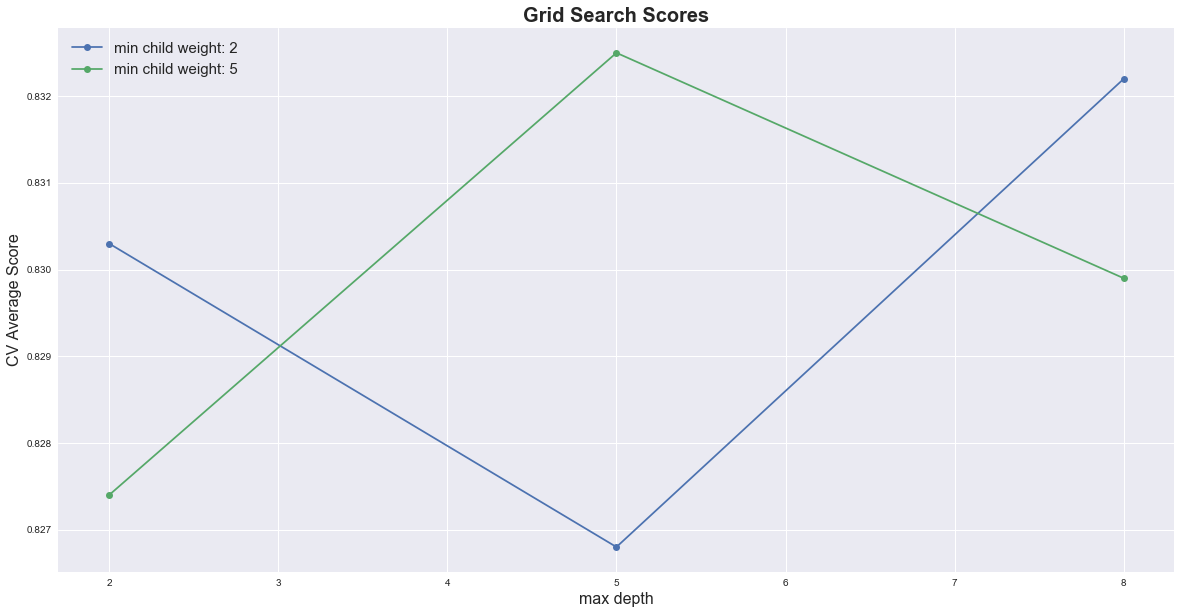

In [33]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')



In [ ]:

plot_grid_search(result.cv_results_, param_test['max_depth'], param_test['min_child_weight'], 'max depth', 'min child weight')